<a href="https://colab.research.google.com/github/shoiTK/deep_learning_with_pytorch/blob/main/torchvision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

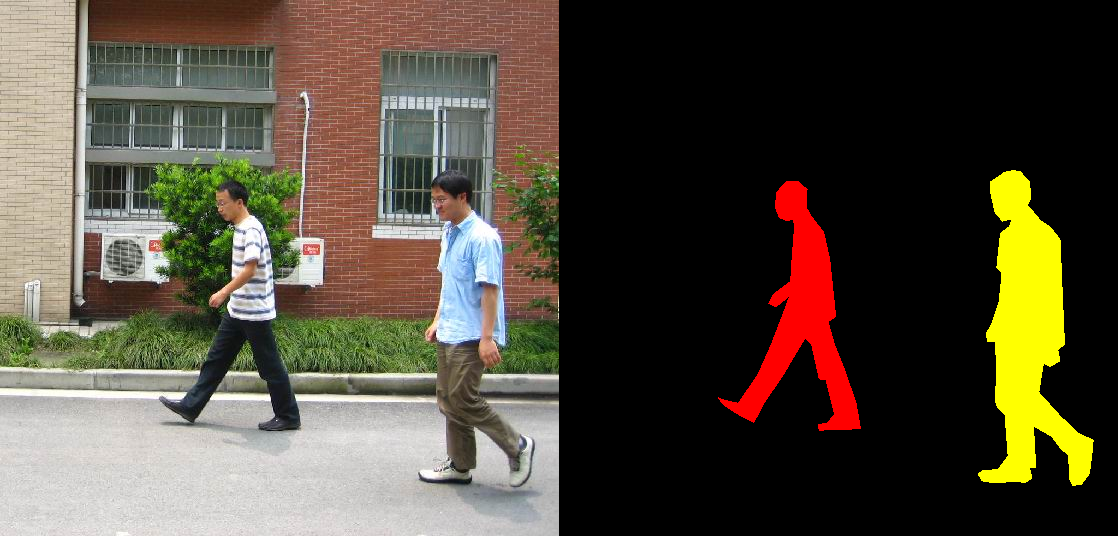

In [19]:
#画像とマスクの表示
from PIL import Image

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

image = Image.open('/content/drive/MyDrive/PennFudanPed/PNGImages/FudanPed00001.png')
mask = Image.open('/content/drive/MyDrive/PennFudanPed/PedMasks/FudanPed00001_mask.png')
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask
get_concat_h(image, mask)

In [3]:
#データセットの画像情報クラス（ボックスサイズ、IDなど）
import os 
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PennFudanDataset(object):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    #全画像ファイルをロードして並び替える
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

#a=PennFudanDataset(object)とするとa[0][0]に画像、a[0][1]にマスクが入る
  def __getitem__(self, idx):
    #画像のロード
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path)
    mask = np.array(mask)
    obj_ids = np.unique(mask)
    #最初のIDは背景なので消去
    obj_ids = obj_ids[1:]
    #オブジェクトの場所をTrueにする
    masks = mask == obj_ids[:, None, None]

    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([idx])
    area = ((boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]))
    iscrowd = torch.zeros((num_objs,),  dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target
  
  def __len__(self):
    return len(self.imgs)


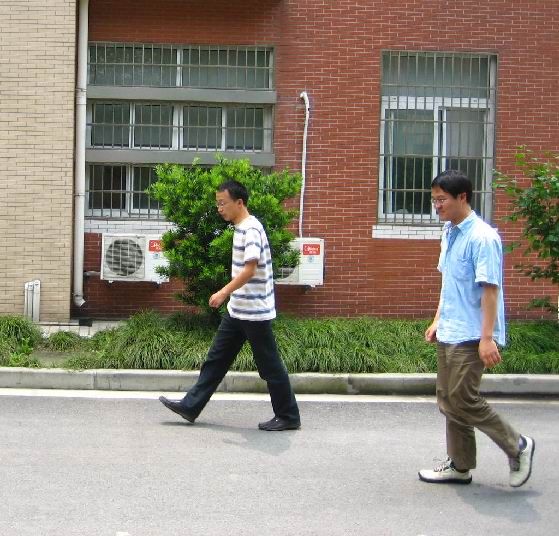

In [4]:
#画像情報の表示
dataset = PennFudanDataset('/content/drive/MyDrive/PennFudanPed/')
dataset[0][0]

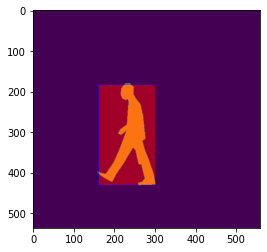

In [7]:
#マスクとボックスの表示
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()
target = dataset[0][1]

# 1番目のインスタンスの masks
masks_0 = target['masks'][0,:,:]
# 1番目のインスタンスの boxes
boxes_0 = target['boxes'][0]
# mask を出力します
ax.imshow(masks_0)
# boxes を出力します
ax.add_patch(
     patches.Rectangle(
        (boxes_0[0], boxes_0[1]),boxes_0[2] - boxes_0[0], boxes_0[3] - boxes_0[1],
        edgecolor = 'blue',
        facecolor = 'red',
        fill=True,
        alpha=0.5
     ) )

plt.show()

In [25]:
#例１：事前学習モデルのロード
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

#事前トレーニングされているモデルをロードする
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#class(person) + background
num_classes = 2
#分類器の入力特徴量を取得する
in_features = model.roi_heads.box_predictor.cls_score.in_features
#事前トレーニングされているHEADを新しいものに交換する
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
#例２：モデルを変更して別のバックボーン(抽出部分)を追加する

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

#サイズ：アンカーボックスのサイズ、アスペクト比：長方形の縦横比
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
model = FasterRCNN(backbone, num_classes=2,
                 rpn_anchor_generator=anchor_generator,
                 box_roi_pool=roi_pooler)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [8]:
#データセットが小さいため事前学習データを使用する
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
  #COCOで事前トレーニングされたモデルをロードする
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  #ボックスの分類器の入力特徴量を取得
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  #FasterRCNNに事前学習データをHEADに加える
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  #マスクの分類器の入力特徴量を取得
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  #MaskRCNNに事前学習データを加える
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                     hidden_layer,
                                                     num_classes)
  return model

In [32]:
import transforms as T

def get_transform(train):
  transforms = []
  transforms.append(T.ToTensor())
  #ランダムに画像と教師データを水平方向に反転する
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [35]:
from engine import train_one_epoch, evaluate
import utils
#GPUの使用
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#オブジェクトと背景の２クラス
num_classes = 2
#データセットクラスのロード
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

#indexをバラバラのリストにする（例：[4, 2, 1, 0, 3]）
indices = torch.randperm(len(dataset)).tolist()

dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

#DataLoader：データの前処理をするモジュール
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
#トレーニング済みの学習データを持つモデルを取得c
model = get_model_instance_segmentation(num_classes)
#GPUで処理を行うため
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
#最適化（SGD）
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#Learning Rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)
#学習回数
num_epochs = 10

for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/60]  eta: 0:02:49  lr: 0.000090  loss: 3.8173 (3.8173)  loss_classifier: 0.5970 (0.5970)  loss_box_reg: 0.1474 (0.1474)  loss_mask: 3.0373 (3.0373)  loss_objectness: 0.0306 (0.0306)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 2.8189  data: 2.0572  max mem: 1755
Epoch: [0]  [10/60]  eta: 0:00:38  lr: 0.000936  loss: 1.5866 (2.1016)  loss_classifier: 0.3709 (0.3944)  loss_box_reg: 0.3095 (0.3018)  loss_mask: 0.8841 (1.3750)  loss_objectness: 0.0262 (0.0245)  loss_rpn_box_reg: 0.0052 (0.0058)  time: 0.7743  data: 0.1930  max mem: 2862
Epoch: [0]  [20/60]  eta: 0:00:26  lr: 0.001783  loss: 0.8354 (1.4280)  loss_classifier: 0.2025 (0.2881)  loss_box_reg: 0.2533 (0.2782)  loss_mask: 0.3476 (0.8365)  loss_objectness: 0.0119 (0.0188)  loss_rpn_box_reg: 0.0064 (0.0063)  time: 0.5652  data: 0.0059  max mem: 2862
Epoch: [0]  [30/60]  eta: 0:00:18  lr: 0.002629  loss: 0.6608 (1.1567)  loss_classifier: 0.1237 (0.2249)  loss_box_reg: 0.2411 (0.2608)  loss_mask: 0.2285 (0.6479)  loss_ob

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
img, _ = dataset_test[3]
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])
print(prediction)

[{'boxes': tensor([[167.1268,  55.4218, 318.8937, 337.7999],
        [  9.3166,  60.4935,  48.6034, 177.3182],
        [250.8820,  62.8726, 326.5350, 306.1332]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9943, 0.9882, 0.1264], device='cuda:0'), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.

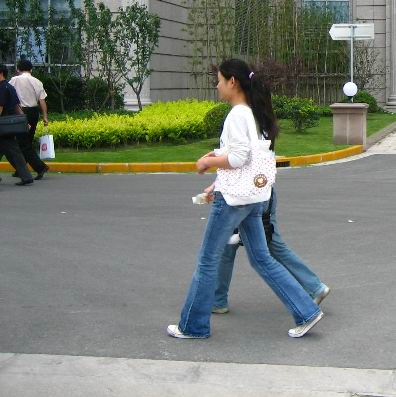

In [43]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

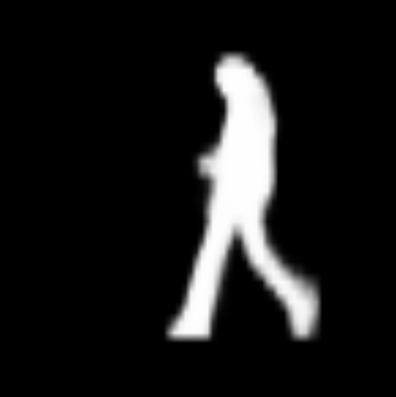

In [44]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())